# DM - SH48 model alignment
This Notebook shows how to align the DM actuator grid w.r.t. the SH sub-aperture grid in the WFPT model to match the actual alignment on the WFPT bench.
It requires:
1. An experimental DM - SH48 interaction matrix (on-axis direction).
2. A synthetic DM - SH48 interaction matrix generated with the WFPT model.

The method is based on comparing DM grids to estimate:
1. DM actuator pitch
2. DM grid shifts
3. DM grid rotation (z-axis)

In [1]:
import numpy as np
import sys
import os
from scipy.optimize import minimize

%matplotlib inline
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display

In [2]:
from ceo import constants, StopWatch
from ceo import wfpt_simul, wfpt_visulib

/home/ubuntu/CEO/python/ceo/zemax


In [3]:
sys.path.append('/home/ubuntu/ocs_wfpt_dcs/src/py/ext/wfptpy/')
sys.path.append('/home/ubuntu/ocs_wfpt_dcs/src/py/ext/wfptpy/wfptpy/controller/modal_controller')
from wfpt_dm_grid_calib import wfpt_dm_grid_calib, grid_model

# Select DM to match

In [4]:
mirror = 'M2'

# Laboratory interaction matrix
Make sure the matrix corresponds to the mirror (M1 or M2) specified above.

In [5]:
exp_dir = '/storage/data02/WFPT_lab_data/20240109_Interaction_Matrices/'
if mirror=='M1':
    fname = 'wfs_response_data_2024_01_09_15_59_17_0.30_ptt1_dm1.npz'
elif mirror=='M2':
    fname = 'wfs_response_data_2024_01_09_16_31_50_0.30_ptt2_dm2.npz'

Not all required information has been saved in the .npz file. Based on private communications with J. Kansky and B. McLeod:
1. The *slopexy* field contains the response matrix of both the PTT (TT-only) and DM. First 14 columns correspond to the PTT commands.
2. The response matrix for the DM (from column 14 onwards) has the response of all DM292 actuators.
3. The command amplitude applied to the DM actuators was A=0.1 [before it was actually saved in the file];
4. The WFS slopes are given in raw units (centroid in pixels);
5. The WFS slopes are ordered as [Sx, Sy] for ALL 50x50 sub-apertures;
6. The measurement was made using a push-pull, and the signal computed as: S(A) = [S(+A) - S(-A)] / 2
7. Only one push-pull was applied per mode measured.
8. The response matrix is measured with a diffraction-limited source (no extended source of 0.8" FWHM is available).
9. The pixel scale has not been measured. It is assumed to be equal to the one in the model for now (0.421 arcsec/pixel).

In addition to *slopexy*, the npz file also contain:
1. *useful_actuators*: actuators considered to be seen by the SH48.
2. *spots_to_use*: index of sub-apertures that lie within the GMT pupil.

In [6]:
expim_data = np.load(os.path.join(exp_dir, fname))
print("Data in file:")
[this_key for this_key in expim_data.keys()]

Data in file:


['slopexy',
 'useful_actuators',
 'spots_to_use',
 'dm_poke_amplitude',
 'ptt_poke_amplitude',
 'subap_flux',
 'dm_num',
 'ptt_num']

Define data needed to interpret the experimental response matrices

In [7]:
#exp_amp = 0.1 # J.Kansky priv. comm
exp_amp = expim_data['dm_poke_amplitude'][()] # Amplitude applied to DM actuators during calibration
exp_pixscale = 0.3 # arcsec / pixel ----> NOTE: TO BE CONFIRMED BY MEASUREMENT.
exp_n_lenslet = 50 # sub-apertures across the grid.

Extract DM-only response matrix data

In [8]:
expIM = expim_data['slopexy'][14:,:].T * exp_pixscale

Extract valid sub-apertures mask

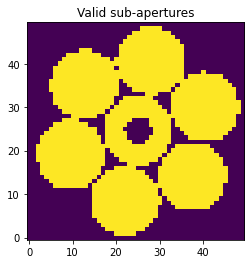

In [9]:
exp_spots = np.squeeze(expim_data['spots_to_use'])
exp_spots_map = np.zeros(exp_n_lenslet**2)
exp_spots_map[exp_spots] = 1
valid_slopes_map = np.concatenate((exp_spots_map,exp_spots_map))
sh_valid_subaps_mask = exp_spots_map.reshape((exp_n_lenslet,exp_n_lenslet))
plt.imshow(sh_valid_subaps_mask, origin='lower')
plt.title('Valid sub-apertures');

Function to reformat the lab SH slopes in 2D

In [10]:
def slopes2d(slopes_vector):
    """
    Returns the sx and sy slopes as maps.
    """
    sx2d = slopes_vector[0:exp_n_lenslet**2].reshape((exp_n_lenslet, exp_n_lenslet))
    sy2d = slopes_vector[exp_n_lenslet**2:].reshape((exp_n_lenslet, exp_n_lenslet))
    return sx2d, sy2d

## Estimate DM grid parameters
We will fit a model of the DM grid using the SH slopes.

In [11]:
exp_grc = wfpt_dm_grid_calib(mirror, expIM, sh_valid_subaps_mask)

### Redefine valid actuators

In [12]:
if mirror == 'M1':
    act_thr = 0.6
elif mirror == 'M2':
    act_thr = 0.56
exp_grc.select_act_subset(act_thr)

A total of 195 actuators selected


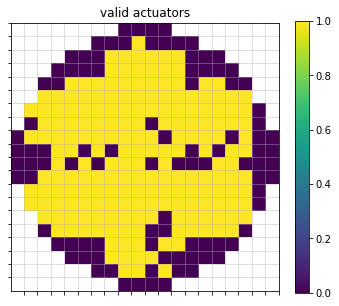

In [13]:
exp_useful_actuators_vec = np.zeros(292)
exp_useful_actuators_vec[exp_grc.act_subset] = 1
wfpt_visulib.show_dm292(exp_useful_actuators_vec, title='valid actuators')

### Fit Gaussian gradients to SH data

In [14]:
exp_grc.set_slopes_gaussian_model_guess()
exp_grc.fit_slopes_gaussian_model()

Gaussian gradient model fitting started...
Gaussian gradient model fitting completed (did not converge for 0 actuators).


In [15]:
@widgets.interact(this_act=(0,291))
def show_gaussfit(this_act=73):
    exp_grc.show_gaussfit(this_act)

interactive(children=(IntSlider(value=73, description='this_act', max=291), Output()), _dom_classes=('widget-i…

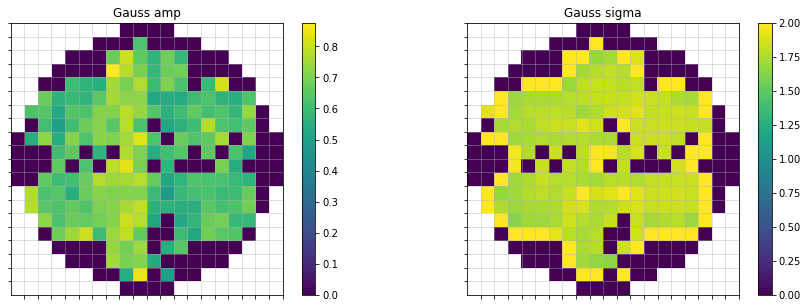

In [16]:
gauss_amps = exp_grc.fit_gauss_model_params[0,:]
gauss_sigma = exp_grc.fit_gauss_model_params[3,:]
fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches((15,5))
wfpt_visulib.show_dm292(gauss_amps, title='Gauss amp', fig=fig, ax=ax1)
wfpt_visulib.show_dm292(gauss_sigma, title='Gauss sigma', fig=fig, ax=ax2)

### Fit the DM grid 
Estimate actuator pitch, shifts and rotation

Compare grids before optimization, and adjust by eye the "best-guess"

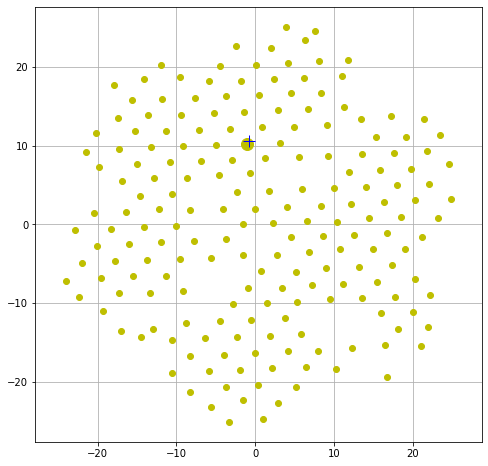

In [17]:
#-- Gaussian gradient fits
peakloc = exp_grc.fit_gauss_model_params[1:3,exp_grc.act_subset]
peakloc[0,:] -= (exp_n_lenslet-1)/2
peakloc[1,:] -= (exp_n_lenslet-1)/2

#-- Initial grid guess
grid0_x, grid0_y = grid_model(mirror, 3,3,-49,0,0)

#-- Plot Gaussian gradient fits and initial grid guess
fig, ax = plt.subplots()
fig.set_size_inches(8,8)
ax.plot(peakloc[0,:], peakloc[1,:], 'yo')
#ax.plot(grid0_x, grid0_y, 'b+', )
ax.axis('equal')
ax.grid()

#-- Highlight an actuator
act_idx = 66
this_act = exp_grc.act_subset[act_idx]
ax.plot(peakloc[0,act_idx], peakloc[1,act_idx], 'yo', markersize=12)
ax.plot(grid0_x[this_act], grid0_y[this_act], 'b+', markersize=12)

Fit the grid (Include scaling, rotation, and shifts)

In [18]:
exp_grc.fit_dm_grid(pitch_init=3, pitch_bound=(2.8,3.2), grid_angle_init=-49, grid_angle_bound=(-55., -40.))
exp_grc.summary()


DM grid model fitting started...
DM grid model fitting completed...
DM grid results
pitch in x: 2.808 SAs
pitch in y: 2.998 SAs
pitch compression (x/y): 0.937
grid rotation (deg): -49.40
grid x-shift: 0.216 SAs
grid y-shift: 0.120 SAs


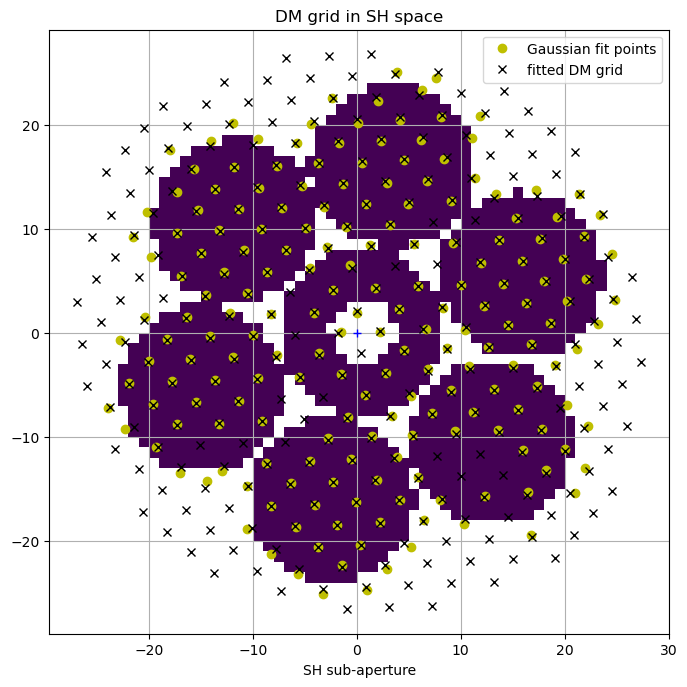

In [19]:
exp_grc.plot_grid()

### Extract grid coordinates and parameters

In [20]:
exp_xact, exp_yact = exp_grc.get_dm_grid()

# Synthetic interaction matrix

## Initialize WFPT model

In [21]:
M2_baffle_diam= 3.6  # size of M2 baffle
project_truss_onaxis=False # simulate truss shadows over central segment
star_mag = 12.0
keep_segments = [1,2,3,4,5,6,7]
wfpt = wfpt_simul(M2_baffle_diam=M2_baffle_diam, project_truss_onaxis=project_truss_onaxis,
                 shs_mag=star_mag, dfs_mag=star_mag, keep_segments=keep_segments)

ZemaxModel does not have attribute IWDP
ZemaxModel does not have attribute EERA
SH48 pixel scale: 0.321 arcsec
ZemaxModel does not have attribute IWDP
ZemaxModel does not have attribute EERA


In [22]:
#--- current values affecting DM magnification
wfpt.shs_path.M1_DM.modes.radius*2, wfpt.shs_path.M2_DM.modes.radius*2

(0.02583545, 0.025950687171701774)

In [23]:
wfpt.dm_default_alignment

{'M1': {'dm_x_shift': -5.931837537882141e-05,
  'dm_y_shift': -0.0002851065575980342,
  'dm_z_rot': 0.0004224370709361102},
 'M2': {'dm_x_shift': -7.332257279909798e-05,
  'dm_y_shift': -8.955094150021824e-05,
  'dm_z_rot': 0.013236816020918134}}

The *calibrate_sensors* method calibrates the reference measurement vectors for both SH and DFS

In [24]:
#--- Set SH illumination threshold to zero to get ALL 52x52 slopes
wfpt.shs_thr = 0.0

#-- Change FWHM of source (set fwhm=0 for DL source)
#wfpt.shs_src.fwhm = 0

wfpt.calibrate_sensors(keep_rays_for_plot=False)

SH source FWHM: 0.642 arcsec
Total SH valid sub-apertures: 2704
SH48 calibration completed.
DFS calibration completed.


## Calibrate DM-SH interaction matrix

In [25]:
%%time
synIM1 = wfpt.shs_path.calibrate(wfpt.shs, wfpt.shs_src, mirror=mirror, mode='actuators', stroke=0.1)

___ M2 ___ (actuators)
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271

In [26]:
np.savez('synIM_DM2.npz', intmat=synIM1)
#synIM1 = dict(np.load('synIM.npz'))['intmat']

The WFPT SH48 model has 52x52 SAs (versus 50x50 as the real SH48). Therefore we need to crop the edges...

In [27]:
synIM = np.zeros(expIM.shape)
for this_act in range(292):
    syn_slopes = synIM1[:, this_act]
    syn_sx2d, syn_sy2d = wfpt.shs.slopes2d(syn_slopes)
    syn_sx2d = syn_sx2d[1:-1,1:-1]
    syn_sy2d = syn_sy2d[1:-1,1:-1]
    synIM[:, this_act] = np.concatenate((syn_sx2d.ravel(), syn_sy2d.ravel()))

In [28]:
syn_pixscale = wfpt.shs.pixel_scale_arcsec
synIM *= constants.RAD2ARCSEC 

## Estimate DM grid parameters
We will fit a model of the DM grid using the SH slopes.

In [29]:
syn_grc = wfpt_dm_grid_calib(mirror, synIM, sh_valid_subaps_mask)

### Redefine valid actuators

In [30]:
if mirror == 'M1':
    act_thr = 0.68
elif mirror == 'M2':
    act_thr = 0.51
syn_grc.select_act_subset(act_thr)

A total of 210 actuators selected


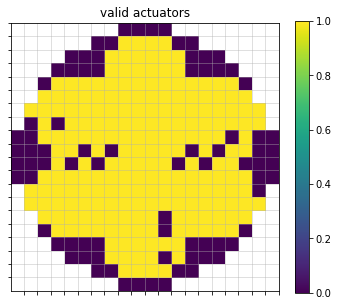

In [31]:
syn_useful_actuators_vec = np.zeros(292)
syn_useful_actuators_vec[syn_grc.act_subset] = 1
wfpt_visulib.show_dm292(syn_useful_actuators_vec, title='valid actuators')

### Fit Gaussian gradients to SH data

In [32]:
syn_grc.set_slopes_gaussian_model_guess()
syn_grc.fit_slopes_gaussian_model()

Gaussian gradient model fitting started...
Gaussian gradient model fitting completed (did not converge for 0 actuators).


In [33]:
@widgets.interact(this_act=(0,291))
def show_gaussfit(this_act=73):
    syn_grc.show_gaussfit(this_act)

interactive(children=(IntSlider(value=73, description='this_act', max=291), Output()), _dom_classes=('widget-i…

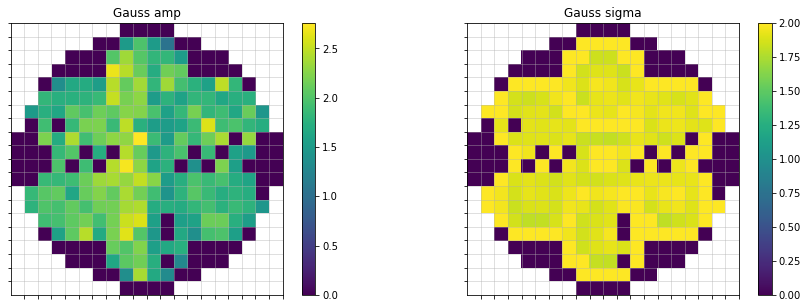

In [34]:
syn_gauss_amps = syn_grc.fit_gauss_model_params[0,:]
syn_gauss_sigma = syn_grc.fit_gauss_model_params[3,:]
fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches((15,5))
wfpt_visulib.show_dm292(syn_gauss_amps, title='Gauss amp', fig=fig, ax=ax1)
wfpt_visulib.show_dm292(syn_gauss_sigma, title='Gauss sigma', fig=fig, ax=ax2)

### Fit the DM grid 
Estimate actuator pitch, shifts and rotation

Compare grids before optimization, and adjust by eye the "best-guess"

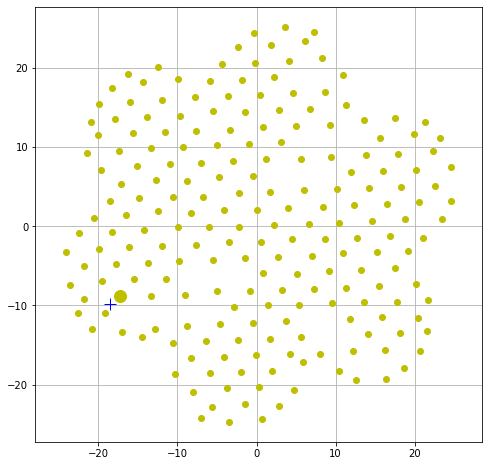

In [35]:
#-- Gaussian gradient fits
syn_peakloc = syn_grc.fit_gauss_model_params[1:3,syn_grc.act_subset]
syn_peakloc[0,:] -= (exp_n_lenslet-1)/2
syn_peakloc[1,:] -= (exp_n_lenslet-1)/2

#-- Initial grid guess
grid0_x, grid0_y = grid_model(mirror, 3,3,-49,0,0)

#-- Plot Gaussian gradient fits and initial grid guess
fig, ax = plt.subplots()
fig.set_size_inches(8,8)
ax.plot(syn_peakloc[0,:], syn_peakloc[1,:], 'yo')
#ax.plot(grid0_x, grid0_y, 'b+', )
ax.axis('equal')
ax.grid()

#-- Highlight an actuator
act_idx = 66
this_act = syn_grc.act_subset[act_idx]
ax.plot(syn_peakloc[0,act_idx], syn_peakloc[1,act_idx], 'yo', markersize=12)
ax.plot(grid0_x[this_act], grid0_y[this_act], 'b+', markersize=12)

Fit the grid (Include scaling, rotation, and shifts)

In [36]:
syn_grc.fit_dm_grid(pitch_init=3, pitch_bound=(2.7,3.2), grid_angle_init=-49, grid_angle_bound=(-55., -40.))
syn_grc.summary()


DM grid model fitting started...
DM grid model fitting completed...
DM grid results
pitch in x: 2.812 SAs
pitch in y: 3.000 SAs
pitch compression (x/y): 0.938
grid rotation (deg): -49.40
grid x-shift: 0.200 SAs
grid y-shift: 0.116 SAs


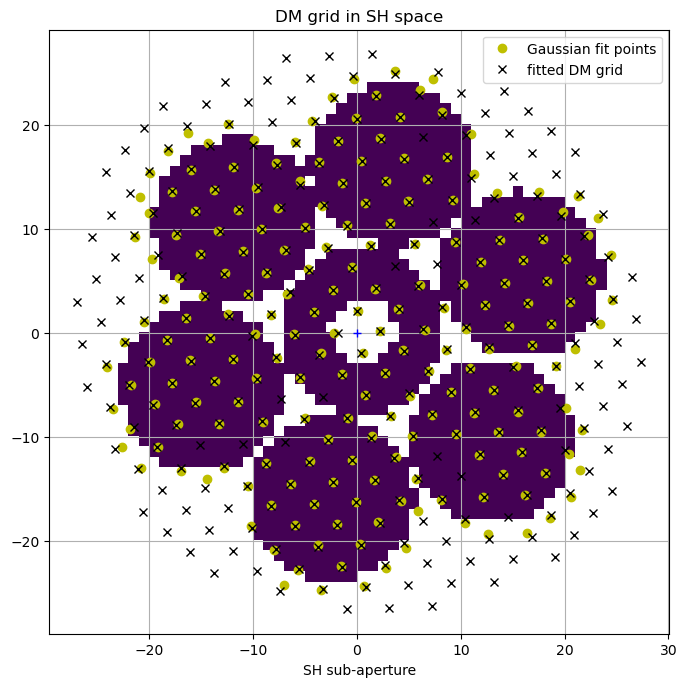

In [37]:
syn_grc.plot_grid()

### Extract grid coordinates and parameters

In [38]:
syn_xact, syn_yact = syn_grc.get_dm_grid()

# Compare lab and synthetic grids

In [39]:
#---- Some by-design parameters
Dtel = 25.4 #diameter of GMT [m]
dm_clear = 26.5e-3 #diameter of DM clear pupil (DM space).
dm_gmt_pup = 24.5e-3 #diameter of GMT pupil (in DM space)
dm_nact_lin = 20 # actuators
theo_dm_pitch = 1.5e-3 #by design from DM292 spreadsheet.
SH48_LENSLET_SIZE = 0.525 # size of SH48 as built on the WFPT [m]

In [40]:
def show_grids(xact1, yact1, xact2, yact2, label1='syn', label2='exp', highlight_act=None, zoom_center=False, title=None):
    fig, ax = plt.subplots()
    fig.set_size_inches((8,8))
    fig.dpi=100
    
    #--- Show GMT pup in SA space
    temp = np.full(sh_valid_subaps_mask.shape, np.nan)
    temp[sh_valid_subaps_mask.astype('bool')] = 1
    Ln = exp_n_lenslet
    ax.imshow(temp, origin='lower', interpolation='none', extent=[-Ln/2, Ln/2, -Ln/2, Ln/2])
    
    #--- Show grids
    ax.plot(xact2, yact2, 'yo', label=label2)
    ax.plot(xact1, yact1, 'kx', label=label1)
    ax.plot(0, 0, 'b+')
    ax.legend()

    #--- Choose an actuator to highlight on both a-priori and data grid (they must coincide)
    if highlight_act is not None:
        this_act = highlight_act
        ax.plot(xact2[this_act], yact2[this_act], 'yo', markersize=12)
        ax.plot(xact1[this_act], yact1[this_act], 'kx', markersize=12)

    ax.grid()
    ax.axis('equal');
    if title is None:
        title='best-fit grids'
    ax.set_title(title)
    
    if zoom_center:
        ax.set_xlim([-5,5])
        ax.set_ylim([-5,5])
    else:
        ax.set_xlim([-30,30])
        ax.set_ylim([-30,30])

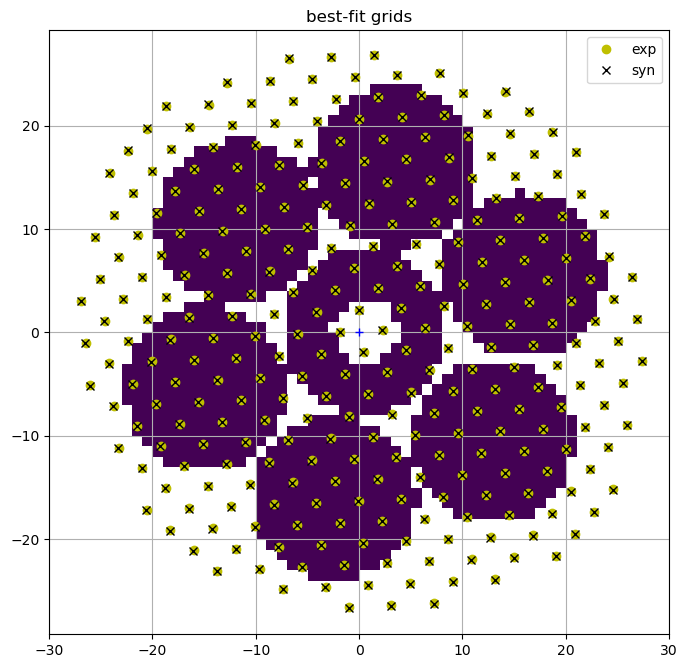

In [42]:
zoom_center=False
show_grids(syn_xact, syn_yact, exp_xact, exp_yact, zoom_center=zoom_center)#, highlight_act=136)

if zoom_center:
    plt.plot(exp_xact[134:138], exp_yact[134:138])

## Pitch compression
The angle of the incident beam on the DM plane is 20.875 deg. As a result, the ratio of the x- and y- pitch should be a factor of 0.934.

In [43]:
#--- By design pitch compression:
theo_pitch_compression = np.cos(20.875*np.pi/180)

#--- Pitch compression estimated from lab data
exp_pitch_compression = exp_grc.pitch_x / exp_grc.pitch_y

#--- Pitch compression estimated from synthetic data
syn_pitch_compression = syn_grc.pitch_x / syn_grc.pitch_y

print('Theo pitch compression: %0.3f'%theo_pitch_compression)
print(' Lab pitch compression: %0.3f'%exp_pitch_compression)
print(' Syn pitch compression: %0.3f'%syn_pitch_compression)

Theo pitch compression: 0.934
 Lab pitch compression: 0.937
 Syn pitch compression: 0.938


Estimated pitch size in meters

In [44]:
# decompressed actuator pitch (synthetic model)
syn_pitch = np.mean([syn_grc.pitch_x / syn_pitch_compression, syn_grc.pitch_y])

# decompressed actuator pitch (lab data)
exp_pitch = np.mean([exp_grc.pitch_x / exp_pitch_compression, exp_grc.pitch_y])

theo_pitch_m = (Dtel/dm_gmt_pup) * theo_dm_pitch
syn_pitch_m  = syn_pitch*SH48_LENSLET_SIZE
exp_pitch_m  = exp_pitch*SH48_LENSLET_SIZE

print("Theo DM pitch projected onto M1: %0.3f m"%theo_pitch_m)
print(" Lab DM pitch projected onto M1: %0.3f m"%exp_pitch_m)
print(" Syn DM pitch projected onto M1: %0.3f m"%syn_pitch_m)

Theo DM pitch projected onto M1: 1.555 m
 Lab DM pitch projected onto M1: 1.574 m
 Syn DM pitch projected onto M1: 1.575 m


Pitch size in meters [derived from fitting of DM IFs]

In [45]:
dm_pitch_0_fit = 1.51388e-3 #from DM_grid_fitting_using_IFs.ipynb
dmfit_pitch_m = (Dtel/dm_gmt_pup) * dm_pitch_0_fit
dmfit_pitch_m

1.5694919183673466

# Fine-tune synthetic DM grid
The goal is to find the magnification, rotation, and shifts to be applied to the DM model in order to match the DM grid as seen in the laboratory SH slopes.

## Estimate magnification, rotation, and shifts
Find the parameters to transform the synthetic grid that provide the best-fit to the lab grid.

In [46]:
def transform_grid(xact_in, yact_in, zoom_cor, grid_rot, grid_shift_x, grid_shift_y):
    
    #---- Apply magnification
    xact_ = xact_in * zoom_cor
    yact_ = yact_in * zoom_cor
    
    #---- Rotate the grid w.r.t center of grid
    ra = -grid_rot*np.pi/180
    xact_out = xact_ * np.cos(ra) - yact_ * np.sin(ra)
    yact_out = xact_ * np.sin(ra) + yact_ * np.cos(ra)
    
    #---- Shift the grid
    xact_out += grid_shift_x
    yact_out += grid_shift_y
    
    return xact_out, yact_out

In [47]:
def fit_grid_err_func(params, *args):
    exp_x_act = args[0]
    exp_y_act = args[1]
    syn_x_act = args[2]
    syn_y_act = args[3]
    #-- Transformation parameters:
    zoom_cor = params[0]
    grid_rot = params[1]
    grid_shift_x = params[2]
    grid_shift_y = params[3]
    fit_x_act, fit_y_act = transform_grid(syn_x_act, syn_y_act, zoom_cor, grid_rot, grid_shift_x, grid_shift_y)
 
    err = ((exp_x_act - fit_x_act) ** 2 + (exp_y_act - fit_y_act) ** 2).sum()
    return err

In [48]:
#-- Initial guess of grid parameters
zoom_cor_init = 1.0
params0 = np.array([zoom_cor_init, 0, 0, 0]) # initial guess

#-- Launch grid fitting procedure
res = minimize(fit_grid_err_func, params0, args=(exp_xact, exp_yact, syn_xact, syn_yact),
         method='Powell', bounds=[(0.95,1.05),
                                  (-5.0,5.0),
                                  (-0.8,  0.8),
                                  (-0.8,  0.8)], options={'disp':True})

final_syn_xact, final_syn_yact = transform_grid(syn_xact, syn_yact, *res.x)

Optimization terminated successfully.
         Current function value: 0.030563
         Iterations: 3
         Function evaluations: 75


In [49]:
zoom_cor = res.x[0]
req_grid_rot = res.x[1]
req_pitch_dx = res.x[2]
req_pitch_dy = res.x[3]

In [50]:
print("Corrections to be applied to the synthetic grid:")
print("-> Magnification correction: %0.3f"%zoom_cor)
print("-> Rotation [deg]: %0.3f"%req_grid_rot)
print("-> x-shift [SAs]: %0.3f"%req_pitch_dx)
print("-> y-shift [SAs]: %0.3f"%req_pitch_dy)

Corrections to be applied to the synthetic grid:
-> Magnification correction: 0.999
-> Rotation [deg]: -0.002
-> x-shift [SAs]: 0.016
-> y-shift [SAs]: 0.005


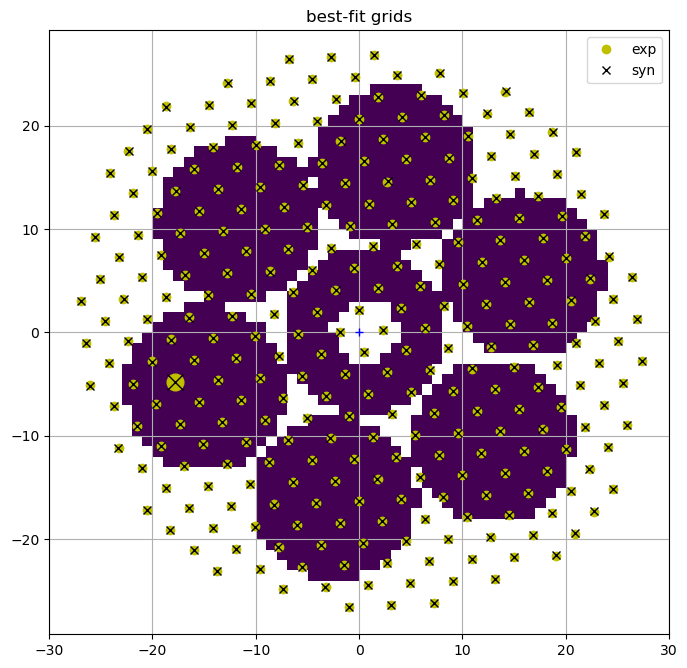

In [51]:
show_grids(final_syn_xact, final_syn_yact, exp_xact, exp_yact, highlight_act=73)

### Grid magnification correction
The magnification correction for the DM model will be implemented by modifying the DM clear pupil value directly in the influence function files (See save_ALPAO_IFs_4_CEO.ipynb).

In [137]:
#--- Check current value for clear aperture in the IF files:
D_clear_current = wfpt.shs_path[mirror+'_DM'].modes.radius*2
print("The current value for the DM clear pupil in the IF files is: %0.3f mm"%(D_clear_current*1e3))

The current value for the DM clear pupil in the IF files is: 25.951 mm


In [138]:
new_dm_clear = D_clear_current * zoom_cor
print('The DM clear aperture in the IF file should be set to %0.2f mm instead of %0.2f mm.'%(new_dm_clear*1e3, D_clear_current*1e3))

The DM clear aperture in the IF file should be set to 25.93 mm instead of 25.95 mm.


### Grid shifts
- The fitting above estimates the x- and y- shifts in the canonical CS.
- CEO needs to know the x- and y- shifts in the (rotated) ALPAO grid CS, in its own coordinate system.

In [144]:
Rz = (syn_grc.grid_rotation + req_grid_rot) * np.pi/180 #Note: positive angle to rotate back (recall that in grid_model() the angle is multiplied by -1).
grid_dx = np.cos(Rz) * req_pitch_dx - np.sin(Rz) * req_pitch_dy
grid_dy = np.sin(Rz) * req_pitch_dx + np.cos(Rz) * req_pitch_dy

grid_dx, grid_dy

(0.17683917699557186, -0.14479248583845197)

We found out that to apply these shifts and rotations in CEO we need to perform this additional transformation:
- $ (x^r, y^r)_{CEO} \leftarrow (y^r, -x^r)$
- (-1) * req_grid_rot
- shift corrections to be implemented with the **dm_grid_alignment()** method of the *wfpt_testbed* class

In [145]:
#---- Shift in SAs units
ceo_grid_dx, ceo_grid_dy = grid_dy, -grid_dx
ceo_grid_dx, ceo_grid_dy

(-0.14479248583845197, -0.17683917699557186)

Shifts expressed in meters in the DM plane.

In [146]:
ceo_grid_dx_m = ceo_grid_dx * SH48_LENSLET_SIZE * (dm_gmt_pup/Dtel)
ceo_grid_dy_m = ceo_grid_dy * SH48_LENSLET_SIZE * (dm_gmt_pup/Dtel)

ceo_grid_dx_m, ceo_grid_dy_m

(-7.332257279909798e-05, -8.955094150021824e-05)

Copy/paste these values onto the wfpt_simul.py file, and use dm_grid_alignment() to apply them.

In [152]:
wfpt.dm_default_alignment[mirror]['dm_x_shift'] + ceo_grid_dx_m, \
wfpt.dm_default_alignment[mirror]['dm_y_shift'] + ceo_grid_dy_m, \
wfpt.dm_default_alignment[mirror]['dm_z_rot'] + (-1)*req_grid_rot*np.pi/180

(-7.332257279909798e-05, -8.955094150021824e-05, 0.013236816020918134)

In [153]:
#--- As reference, these are the previous values.
wfpt.dm_default_alignment[mirror]

{'dm_x_shift': 0.0, 'dm_y_shift': 0.0, 'dm_z_rot': 0.0}

## Characterize shift conversion factor
- The shifts in the wfpt_simul class dm_grid_alignment() method are defined as fraction of the clear pupil (D_clear)
- The shifts in the SH space are measured as fraction of a sub-aperture.

In [78]:
from wfpt_dm_grid_calib import gauss2d_diff_err_func

In [63]:
wfpt.dm_grid_alignment(mirror)

In [95]:
def get_act_pos(mirror, this_act, shift_x=0, shift_y=0):
    wfpt.reset()
    #wfpt.shs_path.M1_DM.motion_CS.reset() # no DM grid shifts
    wfpt.dm_grid_alignment(mirror, dm_x_shift=shift_x, dm_y_shift=shift_y) # default values: all zeros

    #-- Apply a command to the DM
    state = wfpt.state
    state[mirror+'_DM']['actuators'][this_act] = 0.3
    wfpt.update(state)
    
    # Propagate wavefront (SH path)
    wfpt.shs_src.reset()
    wfpt.shs_path.propagate(wfpt.shs_src)
    wfpt.shs.analyze(wfpt.shs_src)
    sx2d, sy2d = wfpt.shs.slopes2d()
    sl_amp2d = np.sqrt(sx2d**2 + sy2d**2)
    sl_amp2d = sl_amp2d[1:-1,1:-1]

    #-- Improve initial guess of actuator position
    params0 = np.zeros(4)
    bounds = []
    
    params0[0] = np.max(sl_amp2d) * 2
    A_bound = (params0[0] / 2, params0[0] * 3 / 2)
    bounds.append(A_bound)
    
    est_mu = np.unravel_index(np.argmax(sl_amp2d), (50, 50), order='F')
    params0[1:3] = est_mu
    bounds.append( (est_mu[0]-2, est_mu[0]+2) )
    bounds.append( (est_mu[1]-2, est_mu[1]+2) )

    params0[3] = 1.8
    bounds.append((1.5, 2.0))
    
    #-- Launch fitting procedure
    res = minimize(gauss2d_diff_err_func, params0, args=(sl_amp2d, 50, sh_valid_subaps_mask),
         method='Powell', bounds=bounds, options={'disp':False})
    xpos, ypos = res.x[1:3]
    return xpos, ypos

In [101]:
#---- 
this_act = 73
xpos0, ypos0 = get_act_pos(mirror=mirror, this_act=this_act)
delta_shift = 0.005
namps = 10
xpos = np.zeros(namps)
ypos = np.zeros(namps)
for jj in range(namps):
    xpos[jj], ypos[jj] = get_act_pos(mirror=mirror, this_act=this_act, shift_x=delta_shift*jj, shift_y=0)
    

In [102]:
xpos0,ypos0, syn_xact[this_act]+(exp_n_lenslet-1)/2, syn_yact[this_act]+(exp_n_lenslet-1)/2

(22.23989937168085, 5.979722711386325, 22.289809696365754, 5.90277569908169)

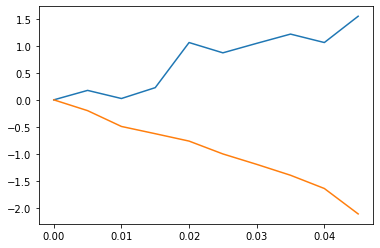

In [107]:
plt.plot(np.arange(namps)*delta_shift, ypos-ypos0)
plt.plot(np.arange(namps)*delta_shift, xpos-xpos0)